# Outline

* Today we will show how to train a ConvNet using PyTorch
* We will also illustrate how the ConvNet makes use of specific assumptions

# To perform well, we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

In [1]:
from res.plot_lib import plot_data, plot_model, set_default

In [2]:
set_default()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import copy

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [5]:
# input_size  = 28*28   # images are 28x28 pixels
# output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

In [6]:
dataloaders = {'train': train_loader, 'val': val_loader}

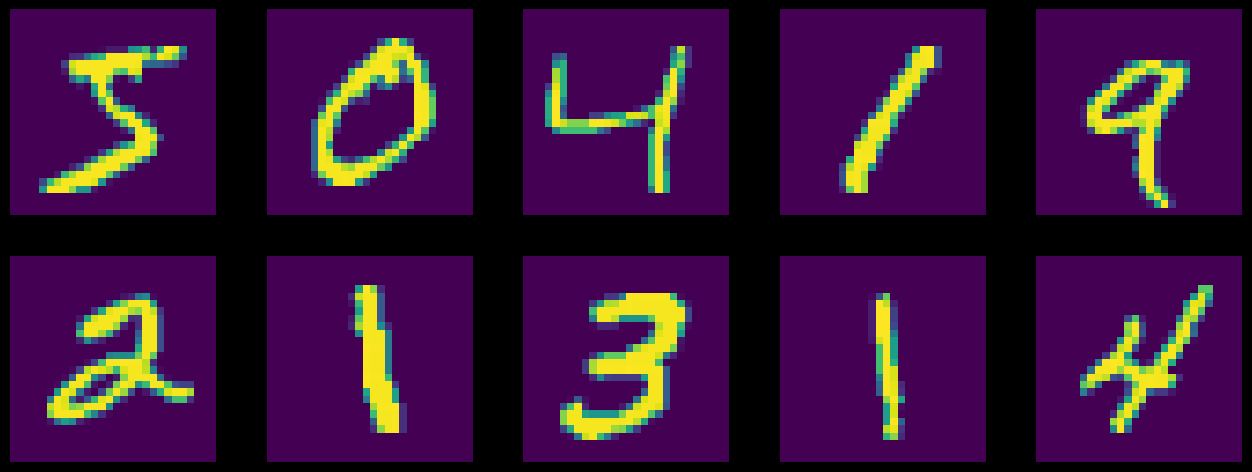

In [7]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# MNIST data properties

We can check the MNIST dataset properties such as:

- shape of train and validation datasets - \[number of samples, width, height\]
- number of input feature on the flattened/reshaped input for fully connected layers

In [8]:
n_features = np.prod(dataloaders['train'].dataset.data.shape[1:])
n_classes = len(dataloaders['train'].dataset.classes)
print("Datasets shapes:", {x: dataloaders[x].dataset.data.shape for x in ['train', 'val']})
print("N input features:", n_features, "Output classes:", n_classes)

Datasets shapes: {'train': torch.Size([60000, 28, 28]), 'val': torch.Size([10000, 28, 28])}
N input features: 784 Output classes: 10


- shape of train and validation batches - \[batch size, number of channels, width, height\]

In [9]:
xb_train, yb_train = next(iter(train_loader))
print("Train batch:", xb_train.shape, yb_train.shape)
xb_val, yb_val = next(iter(val_loader))
print("Test batch:", xb_val.shape, yb_val.shape)

Train batch: torch.Size([64, 1, 28, 28]) torch.Size([64])
Test batch: torch.Size([64, 1, 28, 28]) torch.Size([64])


# Model classes (my take)

In [10]:
class FC2Layer(nn.Module):
    def __init__(self, dim_layers):
        super(FC2Layer, self).__init__()
        self.dim_layers = dim_layers
        modules = [nn.Linear(dim_layers[l], dim_layers[l+1]) for l in range(len(dim_layers) - 1)]
        self.fc_layers = nn.ModuleList(modules)
        
    def forward(self, X):
        X = X.view(-1, self.dim_layers[0]) # get the input with shape (batch_size, num_features = 28*28)
        for layer in self.fc_layers[:-1]:
            X = F.relu(layer(X)) # apply ReLU activation function after each layer (except last layer)
        # we are asked to use nn.NLLLoss() as loss function
        # this function does not apply the log of the softmax of the output activations
        # so we need to apply the log_softmax to the output layer
        return F.log_softmax(self.fc_layers[-1](X), dim = 1)

We will implement a CNN with the following layers:

- convolutional layer with `10 output channels`, `kernel size of 5x5`, and default padding and stride;
- max pooling layer with `kernel size of 2x2`;
- a `ReLU` activation function;
- convolutional layer with `20 output channels`, `kernel size of 5x5`, and default padding and stride;
- `dropout` layer with default probability;
- max pooling layer with `kernel size of 2x2`;
- a `ReLU` activation function;
- affine transformation with `50 output features`;
- a `ReLU` activation function;
- affine transformation with `10 output features` followed by a `log_softmax()`

The initialization (`__init__`) function will define the architecture and the `foward` function will implement how the different layers are connected. This architecture will be a sequece of 2 convolutional layers ([nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) (1st: output channels 10, kernel size 5; 2nd: output channels 20, kernel size 5), then 2 fully connected layers ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) (1st: output features 50; 2nd: output features 10 (the number of classes)). Once again, the final layer will be a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax) function that will choose the most probable class of the 10 in the input.

Between the second convolution layer and the first fully connected, we will set a dropout layer ([nn.Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html)).

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50) # number of input features for linear layer 1 is 20*4*4
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, X):
        # Batch size = 64, images 28x28 =>
        #     X.shape = [64, 1, 28, 28]
        X = F.relu(F.max_pool2d(self.conv1(X), kernel_size=2))
        # Convolution with 5x5 filter without padding and 10 channels =>
        #     X.shape = [64, 10, 24, 24] since 24 = 28 - 5 + 1
        # Max pooling with stride of 2 =>
        #     X.shape = [64, 10, 12, 12]
        X = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(X)), kernel_size=2))
        # Convolution with 5x5 filter without padding and 20 channels =>
        #     X.shape = [64, 20, 8, 8] since 8 = 12 - 5 + 1
        # Max pooling with stride of 2 =>
        #     X.shape = [64, 20, 4, 4]
        # need to reshape the input to the fully connected layer
        X = X.view(-1, 320)
        # Reshape =>
        #     X.shape = [64, 320]
        X = F.relu(self.fc1(X))
        #     X.shape = [64, 50]
        X = self.fc2(X)
        #     X.shape = [64, 10]
        X = F.log_softmax(X, dim = 1)
        
        return X        

# Train and validate model (my take)

In [12]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs = 20, scheduler = None):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # init dictionaries to save losses and accuracies of training and validation
    losses, accuracies = dict(train = [], val = []), dict(train = [], val = [])
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 12)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluation mode
        
            running_loss = 0.
            running_corrects = 0
            n_samples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                n_samples += inputs.shape[0]
                
                # zero the gradient parameters
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs, dim = 1)
                    loss = criterion(outputs, labels) # compute the loss between model output and targets
                    
                    if phase == 'train':
                        loss.backward() # backpropagate the loss with respect to parameters
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.shape[0]
                running_corrects += torch.sum(preds == labels.data)
                
            if scheduler is not None and phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / n_samples
            epoch_acc = running_corrects.double() / n_samples
            
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
        
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, losses, accuracies

# Train a small fully-connected network

In [ ]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

# https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/8
# def count_parameters(model):
    # return sum(p.numel() for p in model.parameters() if p.requires_grad)

Epoch 0/14
------------
train Loss: 0.8093 Acc: 0.7614
val Loss: 0.2841 Acc: 0.9176

Epoch 1/14
------------
train Loss: 0.2511 Acc: 0.9268
val Loss: 0.2056 Acc: 0.9389

Epoch 2/14
------------
train Loss: 0.1780 Acc: 0.9476
val Loss: 0.1560 Acc: 0.9542

Epoch 3/14
------------
train Loss: 0.1374 Acc: 0.9596
val Loss: 0.1255 Acc: 0.9624

Epoch 4/14
------------
train Loss: 0.1098 Acc: 0.9674
val Loss: 0.1100 Acc: 0.9669

Epoch 5/14
------------
train Loss: 0.0904 Acc: 0.9736
val Loss: 0.1011 Acc: 0.9679

Epoch 6/14
------------
train Loss: 0.0759 Acc: 0.9772
val Loss: 0.0938 Acc: 0.9710

Epoch 7/14
------------
train Loss: 0.0640 Acc: 0.9813
val Loss: 0.0920 Acc: 0.9704

Epoch 8/14
------------
train Loss: 0.0546 Acc: 0.9840
val Loss: 0.0822 Acc: 0.9753

Epoch 9/14
------------
train Loss: 0.0468 Acc: 0.9862
val Loss: 0.0816 Acc: 0.9751

Epoch 10/14
------------
train Loss: 0.0405 Acc: 0.9883
val Loss: 0.0875 Acc: 0.9733

Epoch 11/14
------------
train Loss: 0.0346 Acc: 0.9901
val Loss

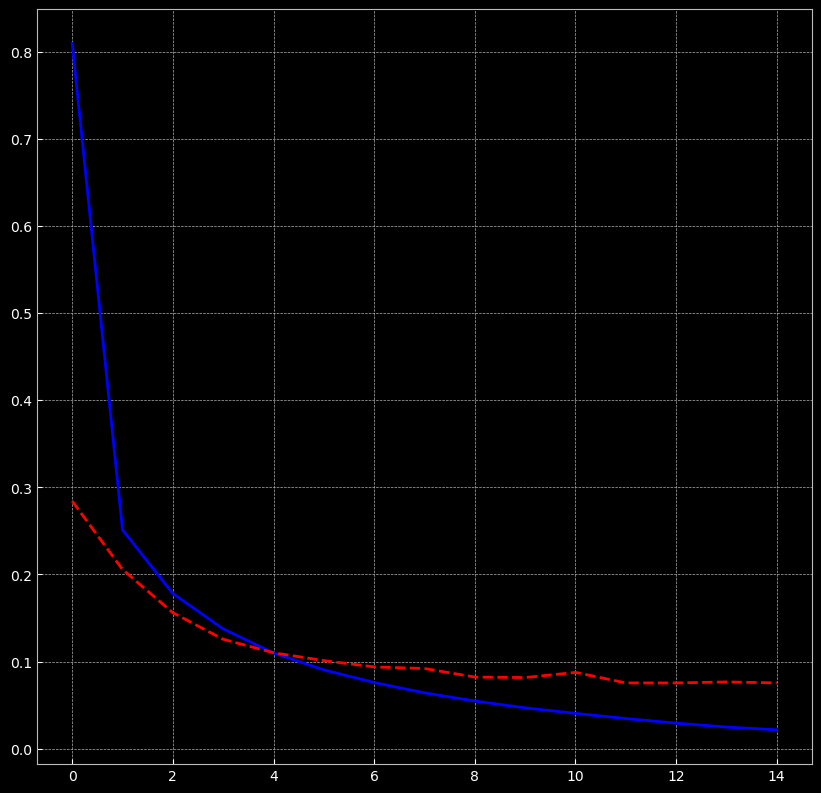

In [14]:
dim_layers = [n_features, 256, 128, 64, n_classes]
model_fc2layer = FC2Layer(dim_layers).to(device)
optimizer = optim.SGD(model_fc2layer.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

model_fc2layer, losses, accuracies = train_val_model(model_fc2layer, criterion, optimizer, dataloaders, num_epochs = 15)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [16]:
print('Number of parameters: {}'.format(get_n_params(model_fc2layer)))

Number of parameters: 242762


# Train a ConvNet with the same number of parameters

Epoch 0/24
------------
train Loss: 0.3288 Acc: 0.9005
val Loss: 0.0859 Acc: 0.9712

Epoch 1/24
------------
train Loss: 0.1288 Acc: 0.9624
val Loss: 0.0560 Acc: 0.9833

Epoch 2/24
------------
train Loss: 0.1034 Acc: 0.9696
val Loss: 0.0477 Acc: 0.9845

Epoch 3/24
------------
train Loss: 0.0883 Acc: 0.9735
val Loss: 0.0455 Acc: 0.9857

Epoch 4/24
------------
train Loss: 0.0811 Acc: 0.9763
val Loss: 0.0432 Acc: 0.9859

Epoch 5/24
------------
train Loss: 0.0721 Acc: 0.9784
val Loss: 0.0371 Acc: 0.9878

Epoch 6/24
------------
train Loss: 0.0676 Acc: 0.9798
val Loss: 0.0391 Acc: 0.9872

Epoch 7/24
------------
train Loss: 0.0654 Acc: 0.9809
val Loss: 0.0309 Acc: 0.9894

Epoch 8/24
------------
train Loss: 0.0613 Acc: 0.9812
val Loss: 0.0290 Acc: 0.9909

Epoch 9/24
------------
train Loss: 0.0568 Acc: 0.9826
val Loss: 0.0339 Acc: 0.9888

Epoch 10/24
------------
train Loss: 0.0523 Acc: 0.9841
val Loss: 0.0336 Acc: 0.9893

Epoch 11/24
------------
train Loss: 0.0531 Acc: 0.9836
val Loss

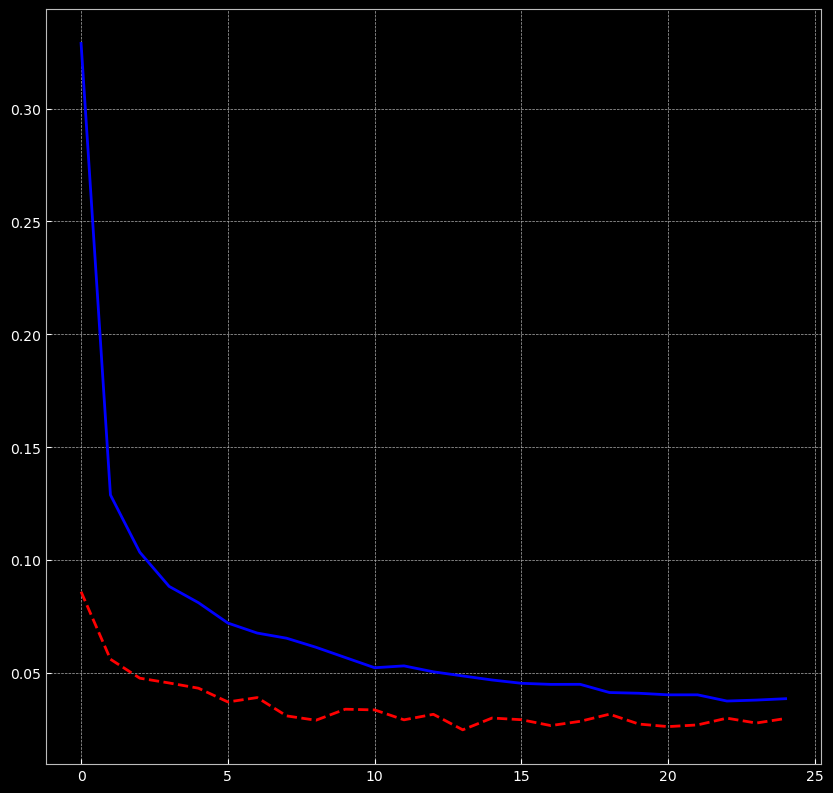

In [19]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=25)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

# Train a fully-connected network with the same number of parameters as CNN

In [21]:
print('Number of parameters: {}'.format(get_n_params(model_fc2layer)))
print('Number of parameters: {}'.format(get_n_params(model)))

Number of parameters: 242762
Number of parameters: 21840


In [22]:
model_fc2layer_test = FC2Layer([n_features, 32, n_classes]).to(device)
print('Number of parameters in the MLP model: {}'.format(get_n_params(model_fc2layer_test)))

Number of parameters in the MLP model: 25450


Epoch 0/14
------------
train Loss: 0.4605 Acc: 0.8753
val Loss: 0.2800 Acc: 0.9208

Epoch 1/14
------------
train Loss: 0.2584 Acc: 0.9250
val Loss: 0.2253 Acc: 0.9343

Epoch 2/14
------------
train Loss: 0.2146 Acc: 0.9387
val Loss: 0.1948 Acc: 0.9452

Epoch 3/14
------------
train Loss: 0.1865 Acc: 0.9472
val Loss: 0.1751 Acc: 0.9488

Epoch 4/14
------------
train Loss: 0.1658 Acc: 0.9526
val Loss: 0.1571 Acc: 0.9535

Epoch 5/14
------------
train Loss: 0.1500 Acc: 0.9577
val Loss: 0.1475 Acc: 0.9560

Epoch 6/14
------------
train Loss: 0.1377 Acc: 0.9609
val Loss: 0.1404 Acc: 0.9592

Epoch 7/14
------------
train Loss: 0.1269 Acc: 0.9638
val Loss: 0.1336 Acc: 0.9594

Epoch 8/14
------------
train Loss: 0.1184 Acc: 0.9666
val Loss: 0.1276 Acc: 0.9612

Epoch 9/14
------------
train Loss: 0.1110 Acc: 0.9683
val Loss: 0.1238 Acc: 0.9618

Epoch 10/14
------------
train Loss: 0.1050 Acc: 0.9699
val Loss: 0.1184 Acc: 0.9638

Epoch 11/14
------------
train Loss: 0.0995 Acc: 0.9718
val Loss

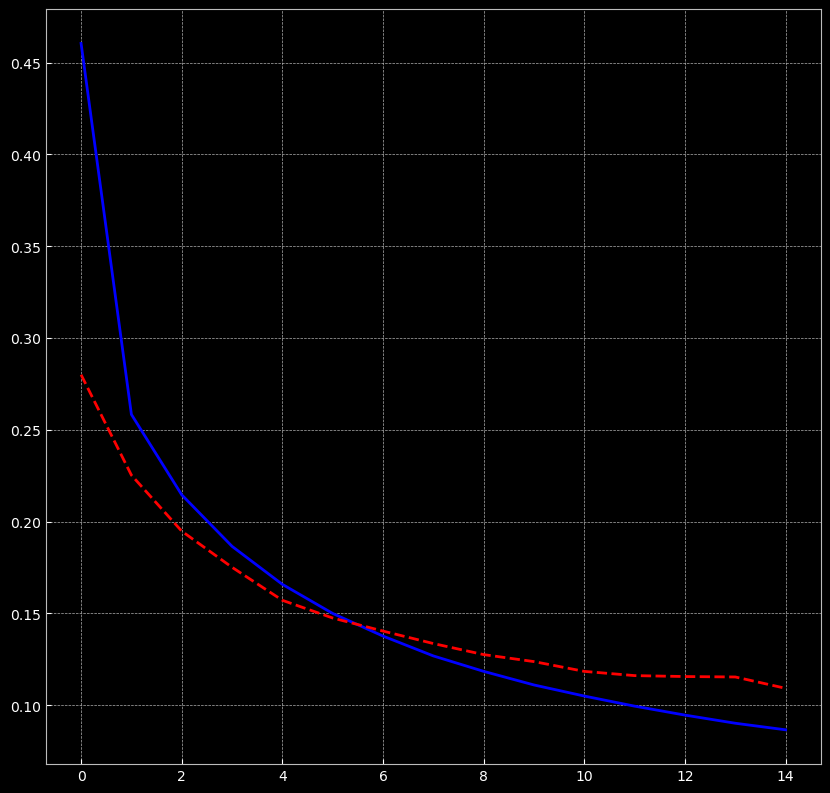

In [23]:
optimizer = optim.SGD(model_fc2layer_test.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

model_fc2layer_test, losses, accuracies = train_val_model(model_fc2layer_test, criterion,
                                                          optimizer, dataloaders, num_epochs = 15)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

# NYU Deep Learning course 2021

In [31]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

## Create the model classes

In [32]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [33]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

## Train a small fully-connected network

In [34]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.280988
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.848775
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.217860
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.850854
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.607350
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.668246
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.681216
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.333001
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.616851
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.341995

Test set: Average loss: 0.4179, Accuracy: 8760/10000 (88%)



## Train a ConvNet with the same number of parameters

In [35]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314522
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.127072
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.484180
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.452839
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.272766
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.155036
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.327817
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.076831
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.112130
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.186109

Test set: Average loss: 0.1999, Accuracy: 9355/10000 (94%)



# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


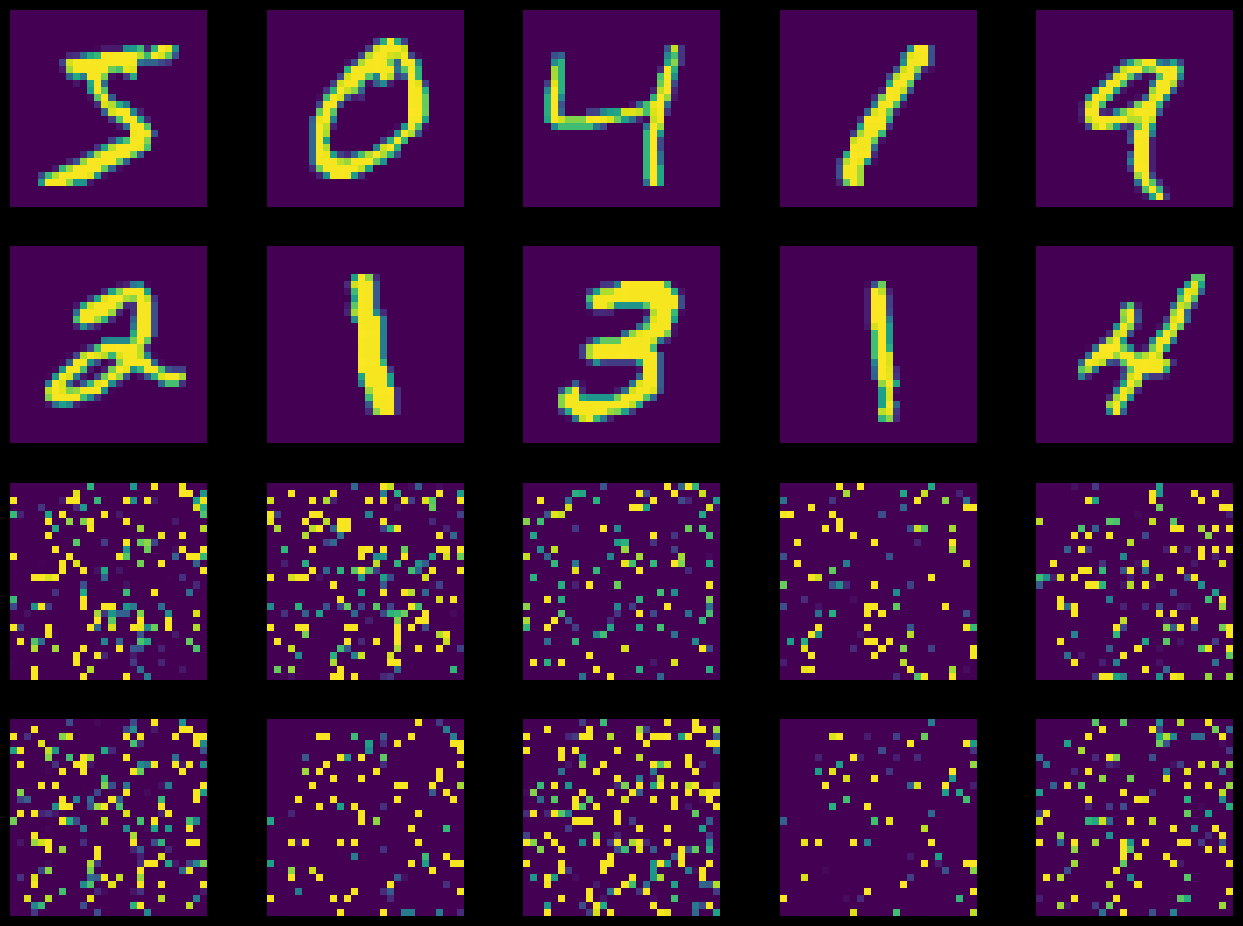

In [36]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

**By shuffling the pixels we lose the locality of the data, so we get a lot less accuracy using the CNN. This goes to show that CNNs work well under the assumption of locality, as well as stationarity and compositionality.**

In [37]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.321598
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.263404
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.161747
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.804520
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.418635
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.226702
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.908495
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.001564
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.759149
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.518456

Test set: Average loss: 0.6688, Accuracy: 7737/10000 (77%)



# Fully-Connected with Permuted Pixels

**Fully-connected layer performs almost as well as the fully-connected layer applied to the unscrambled data. The slight differences might be attributed to statistical variations in the initialisation of the parameters. FC layer doesn't see any kind of differences and the variations we get are the normal expected variations when we run multiple times the same training procedure by using different initialisations.**

In [38]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.318867
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.011600
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.166867
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.743221
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.781399
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.373285
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.427647
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.387690
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.256081
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.388606

Test set: Average loss: 0.4177, Accuracy: 8783/10000 (88%)



# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

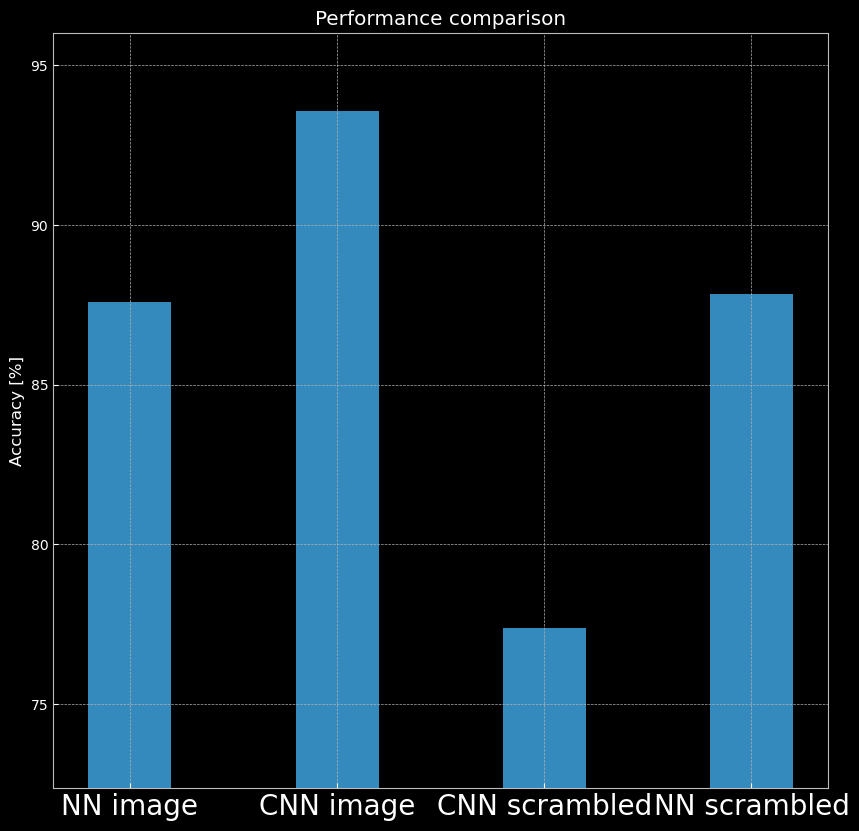

In [39]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');

### Checking Model Parameters

In [40]:
print(dir(model_cnn))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_backward_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', 'children', 'conv1', 'conv2', 'c

In [41]:
print(dir(model_fnn))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_backward_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', 'children', 'cpu', 'cuda', 'doub